# Plates geometry

## Init symbols for *sympy*

In [16]:
from sympy import *
from geom_util import *
from sympy.vector import CoordSys3D
import matplotlib.pyplot as plt
import sys
sys.path.append("../")

%matplotlib inline

%reload_ext autoreload
%autoreload 2
%aimport geom_util

In [17]:
# Any tweaks that normally go in .matplotlibrc, etc., should explicitly go here
%config InlineBackend.figure_format='retina'
plt.rcParams['figure.figsize'] = (12, 12)

plt.rc('text', usetex=True)
    
plt.rc('font', family='serif')

init_printing()

In [31]:
N = CoordSys3D('N')
alpha1, alpha2, alpha3 = symbols("alpha_1 alpha_2 alpha_3", real = True, positive=True)
A,K,rho = symbols("A K rho")

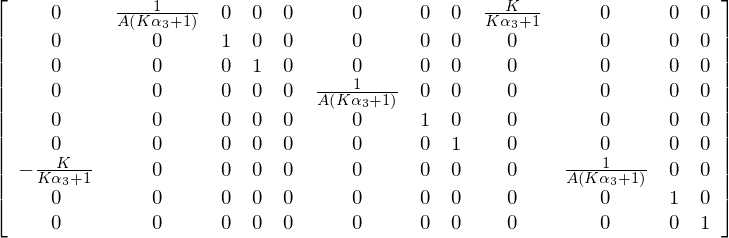

In [32]:
B=Matrix([[0, 1/(A*(K*alpha3 + 1)), 0, 0, 0, 0, 0, 0, K/(K*alpha3 + 1), 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1/(A*(K*alpha3 + 1)), 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [-K/(K*alpha3 + 1), 0, 0, 0, 0, 0, 0, 0, 0, 1/(A*(K*alpha3 + 1)), 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])
B

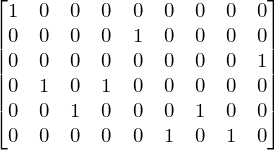

In [33]:
E=zeros(6,9)
E[0,0]=1
E[1,4]=1
E[2,8]=1
E[3,1]=1
E[3,3]=1
E[4,2]=1
E[4,6]=1
E[5,5]=1
E[5,7]=1
E

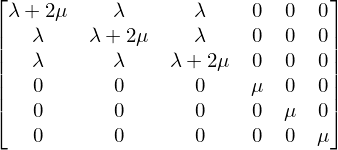

In [34]:
mu = Symbol('mu')
la = Symbol('lambda')
C_tensor = getIsotropicStiffnessTensor(mu, la)
C = convertStiffnessTensorToMatrix(C_tensor)
C

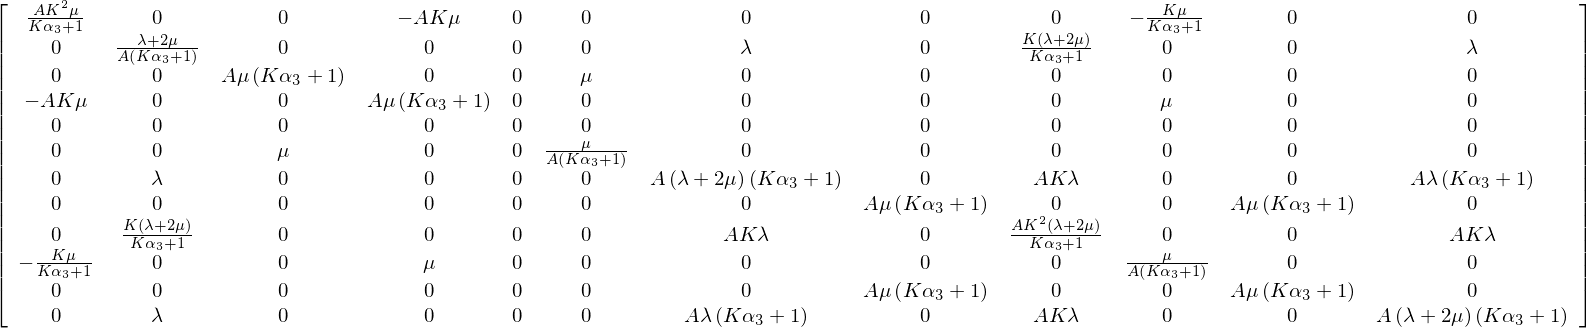

In [35]:
S=B.T*E.T*C*E*B*A*(1+alpha3*K)
S

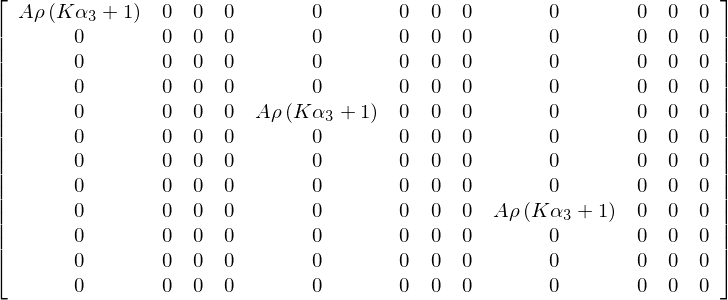

In [47]:
M=Matrix([[rho, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, rho, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, rho, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
M=M*A*(1+alpha3*K)
M

## Cartesian coordinates

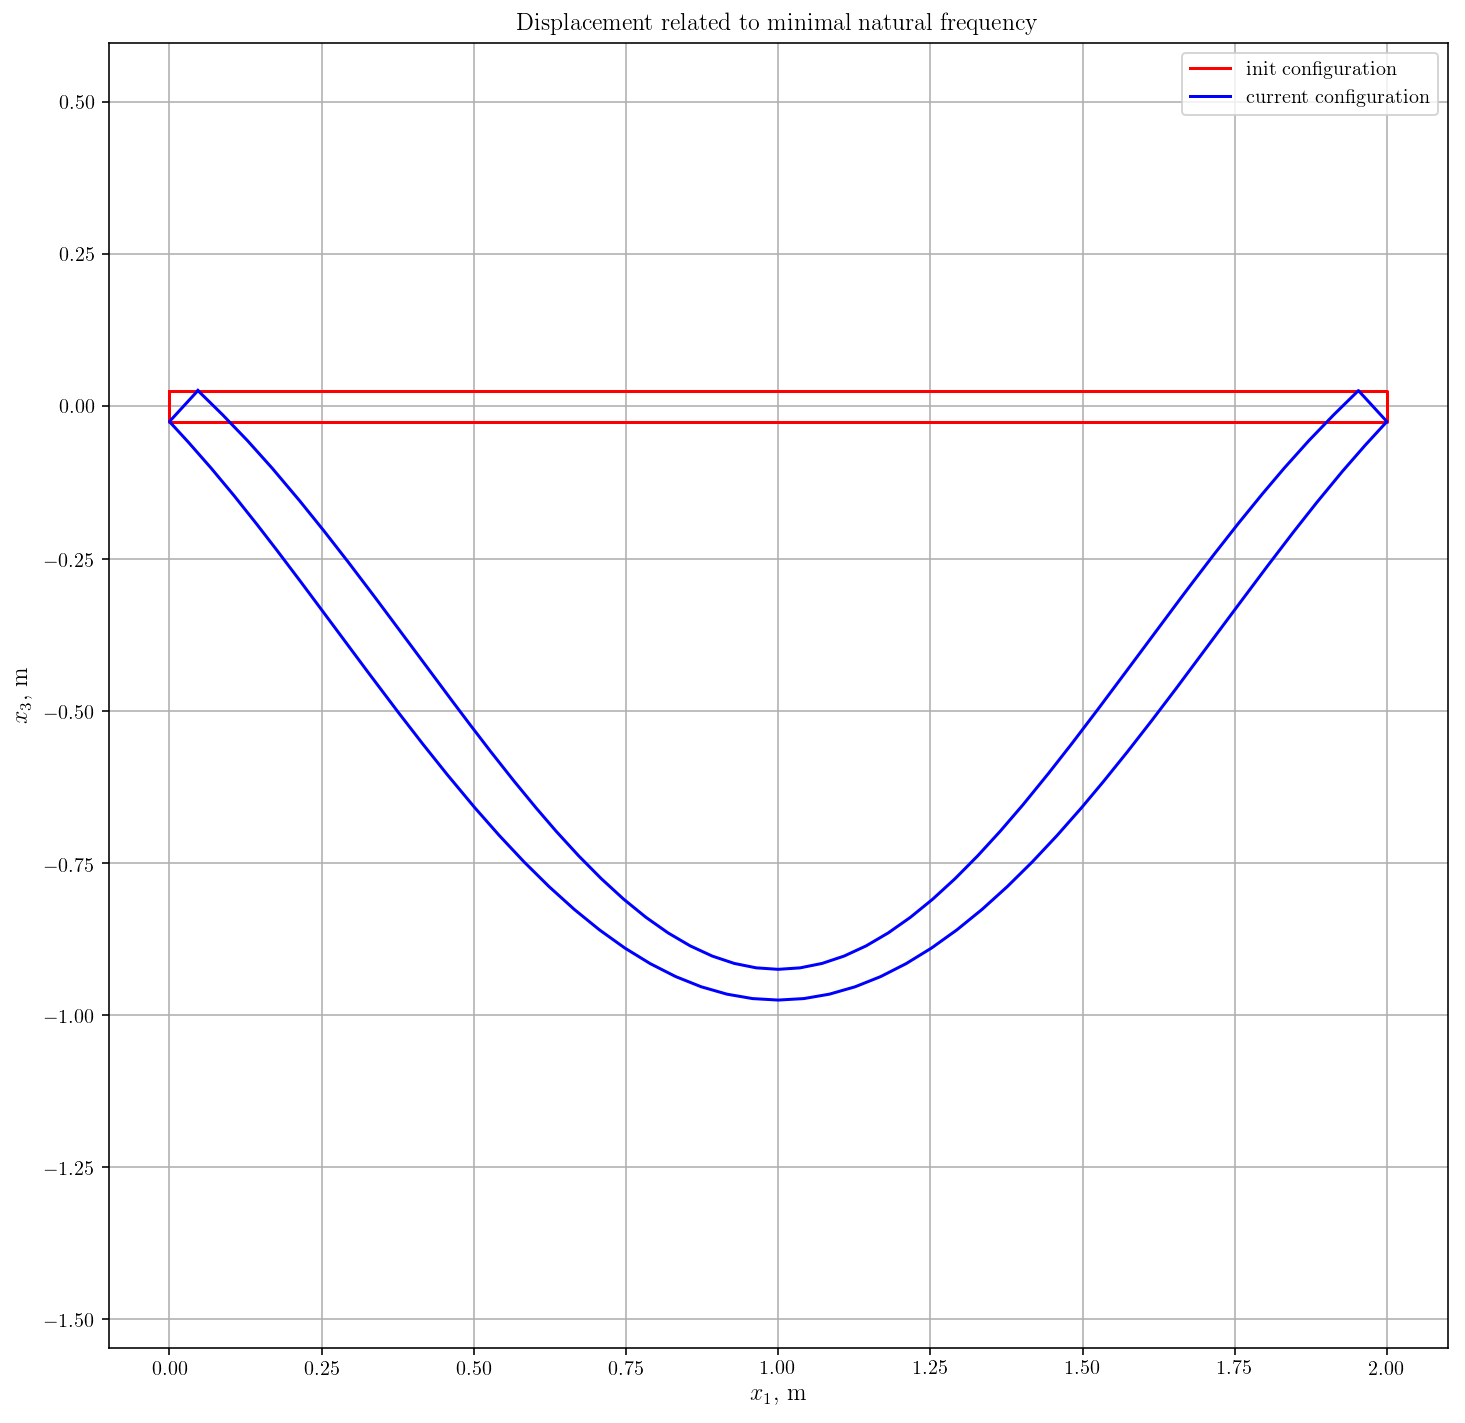

5853.00530859
8351.68823269
13799.0854152
16980.5307612
21981.240589
25476.6576199
30226.0774529
33855.4736227
38421.334695
42094.3421624
46501.6428361
50163.8869418
54419.4471959
58032.8716996
62134.5752946
65669.4930879
69610.4034632
73041.9669607
76812.4932796
80119.1409856


In [50]:
import fem.geometry as g
import fem.model as m
import fem.material as mat
import fem.solver as s
import fem.mesh as me
import plot

stiffness_matrix_func = lambdify([A, K, mu, la, alpha3], S, "numpy")
mass_matrix_func = lambdify([rho, A, K, alpha3], M, "numpy")


def stiffness_matrix(material, geometry, x1, x2, x3):
    return stiffness_matrix_func(1, curvature, material.mu(), material.lam(), x3)

def mass_matrix(material, geometry, x1, x2, x3):
    return mass_matrix_func(material.rho, 1, curvature, x3)



def generate_layers(thickness, layers_count, material):
    layer_top = thickness / 2
    layer_thickness = thickness / layers_count
    layers = set()
    for i in range(layers_count):
        layer = m.Layer(layer_top - layer_thickness, layer_top, material, i)
        layers.add(layer)
        layer_top -= layer_thickness
    return layers


def solve(geometry, thickness, linear):
    layers_count = 1
    layers = generate_layers(thickness, layers_count, mat.IsotropicMaterial.steel())
    model = m.Model(geometry, layers, m.Model.FIXED_BOTTOM_LEFT_RIGHT_POINTS)
    mesh = me.Mesh.generate(width, layers, N, M, m.Model.FIXED_BOTTOM_LEFT_RIGHT_POINTS)
#     if (linear):
    lam, vec = s.solve(model, mesh, stiffness_matrix, mass_matrix)
#     else:
#         lam, vec = s.solve_nl(model, mesh, stiffness_matrix, mass_matrix, stiffness_matrix_nl)
    
    
    return lam, vec, mesh, geometry


# r=2
# width = r*2*3.14
# curvature = 1/r

width = 2
curvature = 0
thickness = 0.05

corrugation_amplitude = 0.03
corrugation_frequency = 20

# geometry = g.CorrugatedCylindricalPlate(width, curvature, corrugation_amplitude, corrugation_frequency)
# geometry = g.CylindricalPlate(width, curvature)
geometry = g.Plate(width)

N = 50
M = 4


lam, vec, mesh, geometry = solve(geometry, thickness, False)
results = s.convert_to_results(lam, vec, mesh, geometry)

results_index = 0
    
# plot.plot_mesh(results[results_index].mesh, width, thickness)
    
# plot.plot_deformed_mesh(results[results_index], width, thickness)
    
plot.plot_init_and_deformed_geometry(results[results_index], 0, width, -thickness / 2, thickness / 2, 0)
    
#    plot.plot_init_geometry(results[results_index].geometry, 0, width, -thickness / 2, thickness / 2, 0)
    
#    for i in range(6):
#        plot.plot_strain_2(results[results_index], N, M, 0, width, -thickness / 2, thickness / 2, 0, i)
#        plot.plot_strain(results[results_index], 0, width, -thickness / 2, thickness / 2, 0, i)
    
    
to_print = 20
if (len(results) < to_print):
    to_print = len(results)
    
for i in range(to_print):
    print(results[i].freq)
